In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
orders = pd.read_csv('orders.csv', delimiter=',')
delivery_windows = pd.read_csv('delivery_windows.csv', delimiter=',')
stores = pd.read_csv('stores.csv', delimiter=',')
addresses = pd.read_csv('addresses.csv', delimiter=',')
replacements = pd.read_csv('replacements.csv', delimiter=',')
cancellations = pd.read_csv('cancellations.csv', delimiter=',')


base = pd.read_csv('base.csv', delimiter=',')
base3 = pd.read_csv('base3.csv', delimiter=',')
fruits = pd.read_csv('fruits.csv', delimiter=',')
numbers = pd.read_csv('numbers.csv', delimiter=',')
one = pd.read_csv('one.csv', delimiter=',')
order_user_rn = pd.read_csv('order_user_rn.csv', delimiter=',')
stream_orders = pd.read_csv('stream_orders.csv', delimiter=',')
customer = pd.read_csv('ЗАКАЗЧИК.csv', delimiter=',')

In [3]:
orders.head()

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
0,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,2018-08-26 02:06:55,888330,1,226459
1,756963,139682,0.0,0.0,7096,0.0,49435,71,shipped,2018-08-26 16:28:41,2018-08-26 05:43:20,888394,1,226460
2,756983,63967,299.0,299.0,2724,-250.0,11590,32,shipped,2018-08-26 15:09:11,2018-08-26 06:12:13,888420,1,226459
3,756985,139687,0.0,0.0,3471,0.0,9915,13,shipped,2018-08-26 18:57:01,2018-08-26 06:13:59,888422,1,226462
4,757066,119006,299.0,299.0,1254,0.0,15022,24,shipped,2018-08-26 13:46:48,2018-08-26 07:40:58,870688,1,226458


In [4]:
def toDateTime(df, name):
    return pd.to_datetime(df[name], format='%Y-%m-%d %H:%M:%S')

def getWeekDay(df, name):
    return toDateTime(df, name).dt.weekday + 1

In [5]:
def numShippingsPerWeekday(df):
    df['weekday'] = getWeekDay(df, 'shipped_at')
    shippings_per_day = \
        [(df[df['weekday'] == i])['shipped_at'].shape[0] for i in range(1, 8)]
    df.drop('weekday', axis=1, inplace=True)
    return shippings_per_day

def numOrdersPerWeekday(df):
    df['weekday'] = getWeekDay(df, 'created_at')
    orders_per_day = [(df[df['weekday'] == i])['created_at'].shape[0] for i in range(1, 8)]
    df.drop('weekday', axis=1, inplace=True)
    return orders_per_day

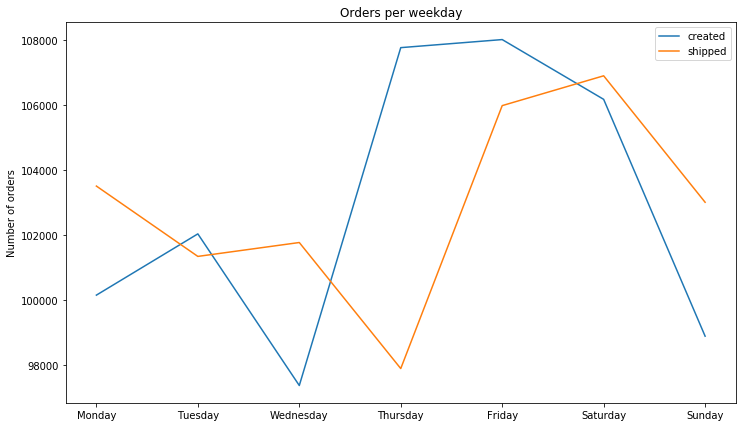

In [6]:
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y_cr = numOrdersPerWeekday(orders)
y_sh = numShippingsPerWeekday(orders)

plt.figure(figsize=(12, 7))

plt.plot(x, y_cr)
plt.plot(x, y_sh)

plt.title('Orders per weekday')
plt.legend(['created', 'shipped'])
plt.ylabel('Number of orders')

plt.show()

Здесь можно заметить интересную особенность: в понедельник, среду, субботу и воскресенье доставок больше, чем оформлений, а, например, в четверг принципиально $($~$10\%)$ меньше. Отсюда можно сделать вывод, что в четверг и в пятницу люди чаще делают заказ на выходные (либо в четверг на вечер пятницы, видимо). Также число оформлений с четверга по субботу явно превосходит остальные дни.

In [7]:
def totalCostPerWeekday(df):
    df['weekday'] = getWeekDay(df, 'created_at')
    cost_per_day = np.array([((df[df['weekday'] == i])['item_total'].sum() +
                             (df[df['weekday'] == i])['total_cost'].sum())
                             for i in range(1, 8)])
    df.drop('weekday', axis=1, inplace=True)
    return cost_per_day

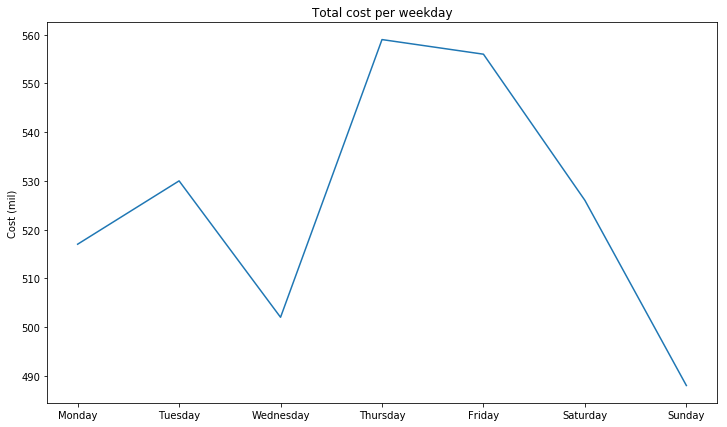

In [8]:
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y = totalCostPerWeekday(orders) // 1000000

plt.figure(figsize=(12, 7))
plt.plot(x, y)

plt.title('Total cost per weekday')
plt.ylabel('Cost (mil)')

plt.show()

Данный график, в целом, сильно похож на предыдущий, но есть нюанс: в субботу и воскресенье средний чек явно меньше, чем в четверг и пятницу. В то время как соотношение суммы заказов к их количеству по будням примерно совпадает, в выходные же совершается больше "мелких" заказов.

Посмотрим, насколько критична разница.

In [9]:
average_check = (totalCostPerWeekday(orders) // numOrdersPerWeekday(orders))
average_check

array([5163., 5196., 5157., 5187., 5151., 4961., 4934.])

In [10]:
average_check.min() / average_check.max()

0.949576597382602

Выходит около $5\%$ между вторником и воскресеньем, что является вполне себе заметной разницей.

Теперь посмотрим на то, как влияют отмены товаров на возвращаемость пользователей.

In [11]:
def cancellationsInfluence(orders, cancellations):
    orders_cancellations = \
    pd.merge(
        orders.drop('state', axis=1),
        cancellations.drop('item_id', axis=1),
        left_on='id',
        right_on='order_id',
        how='left'
    ).drop('order_id', axis=1).drop_duplicates()

    orders_canceled = orders_cancellations[orders_cancellations['state'] == 'canceled']
    orders_not_canceled = orders_cancellations[orders_cancellations['state'] != 'canceled']

    oc = orders_canceled.groupby('user_id').aggregate({'id' : 'count'}).rename(columns={'id' : 'count'})
    onc = orders_not_canceled.groupby('user_id').aggregate({'id' : 'count'}).rename(columns={'id' : 'count'})
    for i in range(10):
        print(f"Больше {i} заказов: \
        {round((oc[oc['count'] > i])['count'].mean(), 4)}, \
        {round((onc[onc['count'] > i])['count'].mean(), 4)}")
              
cancellationsInfluence(orders, cancellations)

Больше 0 заказов:         2.4269,         1.9557
Больше 1 заказов:         4.3745,         4.0119
Больше 2 заказов:         6.1077,         5.9158
Больше 3 заказов:         7.7739,         7.777
Больше 4 заказов:         9.3998,         9.6275
Больше 5 заказов:         10.9806,         11.3602
Больше 6 заказов:         12.5125,         13.0271
Больше 7 заказов:         14.0054,         14.5851
Больше 8 заказов:         15.4895,         16.3036
Больше 9 заказов:         16.8063,         17.9191


В первом столбце можем видеть число заказов, которые совершил пользователь, у которого была хотя бы одна отмена, во втором столбце число заказов, совершённых теми пользователями, у которых ни разу не было отмен. В каждой строке берём среднее по тем пользователям, которые совершили более $i$ заказов. В целом, мы видим, что те "постоянные" пользователи, которые никогда не сталкивались с отменами делают в среднем больше покупок. Постоянными в данном контексте можем назвать тех, кто пользовался услугами СберМаркета хотя бы $4$ раза.

Попробуем проследить за тем, как влияют опоздания курьеров.

In [12]:
def latenessInfluence(orders, delivery_windows):
    orders_delivery = \
    pd.merge(
        orders.drop('state', axis=1),
        delivery_windows.drop(['store_id', 'time_zone'], axis=1),
        left_on='delivery_window_id',
        right_on='id',
        how='left'
    ).drop_duplicates()
    
    early = toDateTime(orders_delivery, 'starts_at') > \
            toDateTime(orders_delivery, 'shipped_at')
    late = toDateTime(orders_delivery, 'shipped_at') > \
            toDateTime(orders_delivery, 'ends_at')
    orders_delivery['early'] = early
    orders_delivery['late'] = late
    orders_delivery['on_time'] = ((orders_delivery['early'] | orders_delivery['late']) == False)
    orders_delivery.drop(['early', 'late'], axis=1, inplace=True)
    
    on_time_rate_table = \
        orders_delivery.groupby('user_id').aggregate \
        (
            {'on_time' : 'sum', 
             'id_x' : 'count'}
        ).rename(columns={'id_x' : 'num_orders'})
    on_time_rate_table['on_time_rate'] = on_time_rate_table['on_time'] / on_time_rate_table['num_orders']
    return np.array([(on_time_rate_table[on_time_rate_table['num_orders'] == i])['on_time_rate'].mean()
                    for i in range(1, 36)])

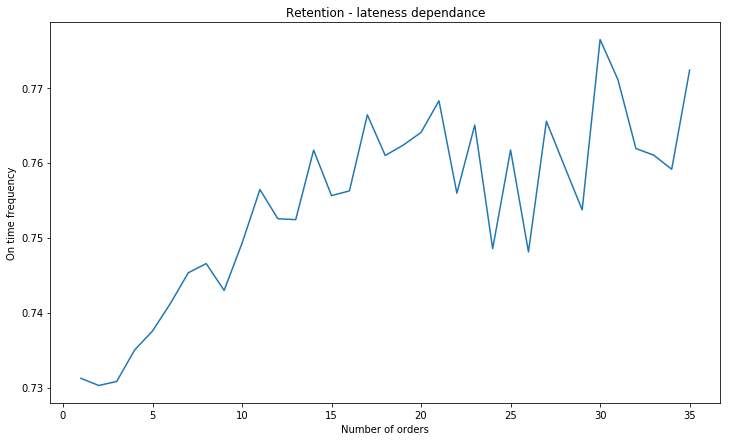

In [13]:
x = np.arange(1, 36, 1)
y = latenessInfluence(orders, delivery_windows)

plt.figure(figsize=(12, 7))
plt.plot(x, y)

plt.title('Retention - lateness dependance')
plt.xlabel('Number of orders')
plt.ylabel('On time frequency')

plt.show()

Из графика ясно видно, что чаще возвращаются те клиенты, чьи заказы доставляют вовремя, причём разница заметная $(3-4\%)$.